# Semantic Text Similarity Exploration
Exploring Text Similarity options and concepts.  The following code is taken or based heavily off of the work done by Zayed Rais and Ali Zahid Raja, which is available [here](https://github.com/zayedrais/DocumentSearchEngine/blob/master/Document%20Search%20Engine.ipynb) and [here](https://medium.com/@zayedrais/build-your-semantic-document-search-engine-with-tf-idf-and-google-use-c836bf5f27fb). 

In [1]:
# First, we're adding our import statements. 
import pandas as pd
import numpy as np
import spacy
import os 
import re
import operator
import pickle
import nltk 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Load the data; in this case, it's the NewsGroup DataSet
# We load the data using the Pandas Dataset. 
news = pd.read_json('https://raw.githubusercontent.com/zayedrais/DocumentSearchEngine/master/data/newsgroups.json')

In [3]:
# Retrieving the document subject through pandas. 
# This function was built by the authors to do that. 

# enumerate provides the index of the contents. 
for i,txt in enumerate(news['content']):
    # Find all is a function of the regular expression library. 
    # In the data, "Subject:" indicates teh subject of the news article. 
    # Therefore, this code will obtain that. 
    subject = re.findall('Subject:(.*\n)',txt)
    if (len(subject) !=0):
        #.loc accesses a group of row/columns by label. 
        news.loc[i,'Subject'] =str(i)+' '+subject[0]
    else:
        news.loc[i,'Subject'] ='NA'

In [4]:
df_news =news[['Subject','content']]

In [5]:
#TextHero - testing to see if this will work better than previous solution.
import texthero as hero

In [6]:
# Now, doing Data Cleaning and Pre-Processing
# Change all the text to lower case. 

from texthero import preprocessing
# https://pypi.org/project/texthero/
# Texthero is a really good library built off of Pandas and it allows for those with minimal knowledge of the NLP space to utilize powerful tools. 

# print(df_news) - if you want to check what data looks like before hand

# How the previous authors did it... this seemed too complicated. 

df_news['content']=[entry.lower() for entry in df_news['content']]

SW=['subject:','organization:','thanks','thank','re:']
for sw in SW:
    df_news.content=df_news.content.replace(to_replace=sw,value='',regex=True)

## data Cleaning for content data of news
df_news.content =df_news.content.replace(to_replace='from:(.*\n)',value='',regex=True) #remove from to email 
df_news.content =df_news.content.replace(to_replace='lines:(.*\n)',value='',regex=True)
df_news.content =df_news.content.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) #remove punctuation except
df_news.content =df_news.content.replace(to_replace='-',value=' ',regex=True)
df_news.content =df_news.content.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.content =df_news.content.replace(to_replace='  ',value='',regex=True)                #remove double white space
df_news.content =df_news.content.apply(lambda x:x.strip())  # Ltrim and Rtrim of whitespace

df_news.Subject =df_news.Subject.replace(to_replace='Re:',value='',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.Subject =df_news.Subject.replace(to_replace='  ',value='',regex=True)    #remove double white space
df_news.Subject =df_news.Subject.apply(lambda x:x.strip())

# print(df_news.content)
# print(df_news.Subject)

# My solution, which works as well! 
# It seems this solution even accounts for common stop words... and it's only three lines of code. 
# https://texthero.org/docs/api-preprocessing

custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls]

# df_news.content = hero.clean(df_news['content'])
# df_news.Subject = hero.clean(df_news['Subject'])
# print(df_news.content) 
# print(df_news.Subject) 

## ## Checking and droping empty data
for i,sen in enumerate(df_news.content):
    if len(sen.strip()) ==0:
        print(str(i))
        #file_data.text[i] = np.nan
        df_news=df_news.drop(str(i),axis=0).reset_index().drop('index',axis=1)

/Users/ronak.k.bhatia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
# Now, doing Word Tokenization
# Tokenization is hwen each entry in the data is broken down into a set of words.
import nltk
nltk.download('punkt')

df_news['Word tokenize']= [word_tokenize(entry) for entry in df_news.content]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ronak.k.bhatia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/Users/ronak.k.bhatia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                #file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [20]:
# My version of lemmatization based on the Coursera code/work I've done previously... 

# Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, 
# normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
# tl;dr put the verbs in their "stem" form. 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [21]:
df_news.shape

(11314, 3)

In [22]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df_clean = wordLemmatizer(df_news['Word tokenize'][0:10]) 
# FOR THE WHOLE DATASET: 
# df_clean = wordLemmatizer(df_news['Word tokenize'])
df_clean

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ronak.k.bhatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ronak.k.bhatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Keyword_final
0,"['car', 'nntp', 'post', 'host', 'university', ..."
1,"['si', 'clock', 'poll', 'final', 'call', 'summ..."
2,"['pb', 'question', 'purdue', 'university', 'en..."
3,"['weitek', 'harris', 'computer', 'system', 'di..."
4,"['shuttle', 'launch', 'question', 'smithsonian..."
5,"['reword', 'second', 'amendment', 'idea', 'vtt..."
6,"['brain', 'tumor', 'treatment', 'reply', 'bmde..."
7,"['ide', 'vs', 'scsi', 'new', 'mexico', 'state'..."
8,"['win', 'icon', 'help', 'please', 'university'..."
9,"['sigma', 'design', 'double', 'article', 'univ..."


In [23]:
df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
df_clean=df_clean.replace(to_replace ="'", value = '', regex = True)
df_clean=df_clean.replace(to_replace =" ", value = '', regex = True)
df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)
df_clean

,Keyword_final
0,"car,nntp,post,host,university,maryland,college..."
1,"si,clock,poll,final,call,summary,final,call,si..."
2,"pb,question,purdue,university,engineering,comp..."
3,"weitek,harris,computer,system,division,distrib..."
4,"shuttle,launch,question,smithsonian,astrophysi..."
5,"reword,second,amendment,idea,vtt,article,cdt,t..."
6,"brain,tumor,treatment,reply,bmdelane,universit..."
7,"ide,vs,scsi,new,mexico,state,university,la,cru..."
8,"win,icon,help,please,university,northern,iowa,..."
9,"sigma,design,double,article,university,illinoi..."


In [24]:
# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
# This is using my version. 
df_clean = lemmatization(df_news['Word tokenize'][0:10], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(df_clean)

['car nntp post host rac3.wam.umd.edu wonder out could enlighten car see other day door sport car look late early 70 call bricklin door really small addition front bumper separate rest body know can tellme model name engine spec year production where car make history info funky look car e mail bring neighborhood lerxst', 'si final summary final call si clock report keyword si acceleration clock post host carson.u.washington.edu fair number brave soul upgrade si clock oscillator share experience poll send brief message detail experience procedure top speed attain rated speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request will summarize next day so add network knowledge base do clock upgrade answer poll', 'pb question computer network distribution folk finally give ghost weekend start life way back market new machine bit soon intend look pick powerbook maybe bunch question hopefully can answer know dirt when next round powerbook introduction

In [25]:
#Add Lemmatized words to the dataframe
## Insert New column in df_news to stored the Clean Keyword
# df_news.insert(loc=3, column='Clean_Keyword', value=df_clean['Keyword_final'].tolist())

In [26]:
## Already Word lemmatize clean keywords the below path:-
#df_news[['Subject','Clean_Keyword']].to_json("WordLemmatize20NewsGroup.json")
df = pd.read_json('https://raw.githubusercontent.com/zayedrais/DocumentSearchEngine/master/data/WordLemmatize20NewsGroup.json')
df_news['Clean_Keyword'] = df['Clean_Keyword']

In [27]:
df_news_save= df_news
df_news_save = df_news_save.drop(['Word tokenize','Clean_Keyword'],axis=1)
df_news_save

,Subject,content
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...
2,2 PB questions,pb questions... purdue university engineering ...
3,3 Weitek P9000,weitek p9000 harris computer systems division ...
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...
...,...,...
11309,11309 Migraines and scans,migraines and scans distribution world inventi...
11310,11310 Screen Death Mac Plus 512,screen death mac plus 512 tufts university med...
11311,11311 Mounting CPU Cooler in vertical case,mounting cpu cooler in vertical case mail grou...
11312,11312 Sphere from 4 points,sphere from 4 points central research lab. hit...


In [42]:
# Saving the data into a CSV Format
df_news_save.to_csv("df_news_index.csv", index=False, header=True)

In [43]:
#df_news =pd.read_csv("df_news.csv")
## Sample of clean keywords
df_news.Clean_Keyword[0]

'thing,car,nntp,post,host,university,maryland,college,park,line,wonder,anyone,could,enlighten,car,saw,day,sport,car,look,late,early,call,bricklin,door,really,small,addition,front,bumper,separate,rest,body,know,anyone,tellme,model,name,engine,spec,year,production,car,make,history,whatever,info,funky,look,car,please,mail,il,bring,neighborhood,lerxst'

Now, using TF-IDF to create a document search tool. TF-IDF is the process of calculating the weight of each word (signifying the importance of the word in the corpus/document). The algorithm is used mainly for retrieving information and text mining. 

* TF (Term Frequency) is how many times a word appears in a document divided by the number of the words in the document. 

* IDF (Inverse Data Frequency) is the log of the number of documents divided by the number of documents with the word W that we're interested in. 

TF-IDF is just these two numbers multiplied together - sklearn implements this feature for you in their library. 

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

## Create Vocabulary
vocabulary = set()

for doc in df_news.Clean_Keyword:
    vocabulary.update(doc.split(','))

vocabulary = list(vocabulary)

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary,dtype=np.float32)

# Fit the TfIdf model
tfidf.fit(df_news.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df_news.Clean_Keyword)

In [45]:
vocabulary[0:4] # for example

['papilloma', 'pointermotionmask', 'horde', 'wodziak']

In [46]:
# Saving the trained TF-ID Model
# I uploaded this to Colab and then ran this. 
with open('/Users/ronak.k.bhatia/Desktop/Data_STA/tfid.pkl','wb') as handle:
    pickle.dump(tfidf_tran, handle)

# Load the model! 
t = pickle.load(open('/Users/ronak.k.bhatia/Desktop/Data_STA/tfid.pkl','rb'))

In [47]:
# Saving the vocabulary
# Also added this file to Colab to run it! 

# Saving the vocabulary
with open("/Users/ronak.k.bhatia/Desktop/Data_STA/vocabulary_news20group.txt", "w") as file:
    file.write(str(vocabulary))

### Loading the vocabulary 
with open("/Users/ronak.k.bhatia/Desktop/Data_STA/vocabulary_news20group.txt", "r") as file:
    data2 = eval(file.readline())


In [48]:
# Creating vector for Query/Search Keywords
def gen_vector_T(tokens):

    Q = np.zeros((len(vocabulary)))
    
    x= tfidf.transform(tokens)
    for token in tokens[0].split(','):
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

Cosine similarity is the most common metric used to calculate the similarity between document text from input keywords/sentences. It measures the cosine of the angle between two vectors projected in a multi-dimensional space. 

In [49]:
# Calculating Cosine Similarity with the Formula
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [50]:
# Calculating Cosine Similarity of the Trained TF-IDF to Input Query

def cosine_similarity_T(k, query):
    #print("Cosine Similarity")
    # This cleans up the query that a user has. 
    preprocessed_query = preprocessed_query = re.sub("\W+", " ", query).strip()
    tokens = word_tokenize(str(preprocessed_query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
    #print("\nQuery:", query)
    #print("")
    #print(tokens)
    
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    
    for d in tfidf_tran.A:
        
        d_cosines.append(cosine_sim(query_vector, d))
                    
    out = np.array(d_cosines).argsort()[-k:][::-1]
    #print("")
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    for i,index in enumerate(out):
        a.loc[i,'index'] = str(index)
        a.loc[i,'Subject'] = df_news['Subject'][index]
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

In [51]:
%time cosine_similarity_T(10,'engineering')

CPU times: user 11.1 s, sys: 4.79 s, total: 15.9 s
Wall time: 3.08 s


,index,Subject,Score
0,4745,4745 DoD Books,0.219301
1,1650,1650 RasterOps 8XL,0.212578
2,515,515 LOOKING FOR THE LATEST ACTIX DRIVERS FOR W...,0.202829
3,4366,4366 Computer Engr vs Computer Science,0.181360
4,2540,2540 68LC040 vs 68RC040 in Centris 650,0.176790
5,9601,9601 Summer Internships,0.176644
6,10557,10557 Pantheism Environmentalism,0.168098
7,167,167 Texas Ranger Ticket Info,0.165404
8,8920,8920 Honors Degrees Do they mean anything,0.164479
9,3673,3673 JOB,0.160078


Of course, this is one way to do this. However, another way is by using Google's Universal Sentence Encoder! 

In [52]:
!pip install --upgrade tensorflow-gpu
#Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [53]:
# Yay more imports
import pandas as pd
import numpy as np
import re, string
import os 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

In [54]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


In [56]:
# Loading the Google Universal Sentence Encoder's pretrained Model 

base_dir = "/Users/ronak.k.bhatia/Desktop/Data_STA/"

print(base_dir)

%time model = hub.load(base_dir)
# print ("module %s loaded" % module_url)

# #Create function for using modeltraining
def embed(input):
    return model(input)

/Users/ronak.k.bhatia/Desktop/Data_STA/
CPU times: user 6.19 s, sys: 1.33 s, total: 7.52 s
Wall time: 7.61 s


The following functions are provided use cases of Google's USE (universal sentence encoder) model. Google USE is a pre-trained universal sentence encoder that's publicly available in TensorFlow-Hub. It comes in two variations: one is trained with a transformer encoder and another trained with a deep averaging network. The former is more accurate but more computationally expensive; the latter is less accurate but faster. 

In [57]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Similarity")

In [58]:
def run_and_plot_U(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

In [59]:
def SimilarityScore(messages):
    message_embedding = embed(messages)
    corr = np.inner(message_embedding,message_embedding)
    #for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    #    print("Message: {}".format(messages[i]))
    print(corr)

In [60]:
# Use Case: Word Semantics
WordMessage =['big data', 'millions of data', 'millions of records','cloud computing','aws','azure','saas','bank','account']

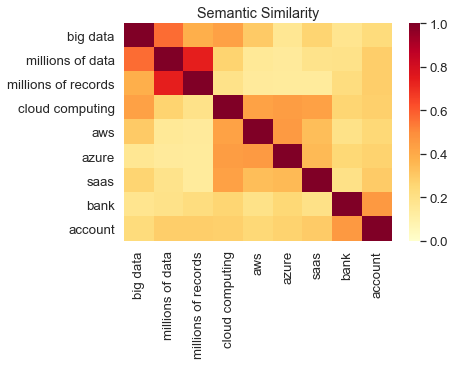

In [61]:
run_and_plot_U(WordMessage) 

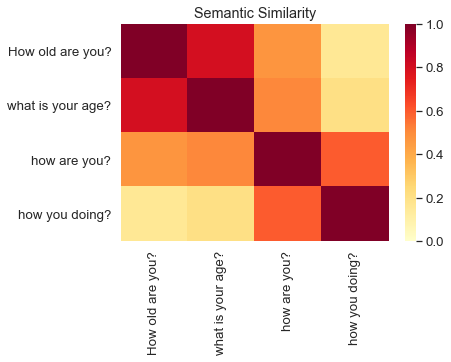

In [64]:
# Use Case: Semantic Similarity 
SentMessage =['How old are you?','what is your age?','how are you?','how you doing?']
run_and_plot_U(SentMessage)

In [65]:
# Use Case #3: Word, Sentence, and Paragram Semantic 
word = 'Cloud Computing' 
Sentence = 'What is Cloud Computing?'
Para =("Cloud computing is the latest generation technology with a high IT infrastructure that provides us a means by which we can use and utilize the applications as utilities via the internet."
        "Cloud computing makes IT infrastructure along with their services available 'on-need' basis." 
        "The cloud technology includes - a development platform, hard disk, computing power, software application, and database.")
Para5 =(
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
Para6 =("Azure is a cloud computing platform which was launched by Microsoft in February 2010."
       "It is an open and flexible cloud platform which helps in development, data storage, service hosting, and service management."
       "The Azure tool hosts web applications over the internet with the help of Microsoft data centers.")
case4Message=[word,Sentence,Para,Para5,Para6]

SimilarityScore(case4Message)

[[ 1.0000001   0.7828857   0.5078861   0.01781904  0.5038207 ]
 [ 0.7828857   1.0000002   0.5534512  -0.03384617  0.5246218 ]
 [ 0.5078861   0.5534512   1.          0.05925354  0.58710694]
 [ 0.01781904 -0.03384617  0.05925354  1.0000001   0.01667345]
 [ 0.5038207   0.5246218   0.58710694  0.01667345  0.9999999 ]]


In [66]:
len(df_news.content)

11314

Now, let's train the Google USE Model using Batch-wise Chunk Size (1000 rows). 

In [70]:
ls =[]
chunksize =1000
le =len(df_news.content)
for i in range(0,le,chunksize):
    if(i+chunksize > le): 
        chunksize= le;
        ls.append(chunksize)
    else:
        a =i+chunksize
        ls.append(a)
ls
j=0

print(os)

for i in ls:
    directory = "/Users/ronak.k.bhatia/Desktop/Data_STA/" + str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)
    directory = "/Users/ronak.k.bhatia/Desktop/Data_STA/" + str(i)
    print(j,i) 
    m=embed(df_news.content[j:i])
    exported_m = tf.train.Checkpoint(v=tf.Variable(m))
    exported_m.f = tf.function(
    lambda  x: exported_m.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

    tf.saved_model.save(exported_m,directory)
    j = i
    print(i)

<module 'os' from '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/os.py'>
0 1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/1000/assets
1000
1000 2000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/2000/assets
2000
2000 3000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/3000/assets
3000
3000 4000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/4000/assets
4000
4000 5000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/5000/assets
5000
5000 6000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/6000/assets
6000
6000 7000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/7000/assets
7000
7000 8000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/8000/assets
8000
8

In [71]:
# Batch-wise, loading the model! 
for i in ls:
    directory = "/Users/ronak.k.bhatia/Desktop/Data_STA/" + str(i)
    if os.path.exists(directory):
        print(directory)
        imported_m = tf.saved_model.load(directory)
        a= imported_m.v.numpy()
        #print(a)
        exec(f'load{i} = a')

/Users/ronak.k.bhatia/Desktop/Data_STA/1000
/Users/ronak.k.bhatia/Desktop/Data_STA/2000
/Users/ronak.k.bhatia/Desktop/Data_STA/3000
/Users/ronak.k.bhatia/Desktop/Data_STA/4000
/Users/ronak.k.bhatia/Desktop/Data_STA/5000
/Users/ronak.k.bhatia/Desktop/Data_STA/6000
/Users/ronak.k.bhatia/Desktop/Data_STA/7000
/Users/ronak.k.bhatia/Desktop/Data_STA/8000
/Users/ronak.k.bhatia/Desktop/Data_STA/9000
/Users/ronak.k.bhatia/Desktop/Data_STA/10000
/Users/ronak.k.bhatia/Desktop/Data_STA/11000
/Users/ronak.k.bhatia/Desktop/Data_STA/11314


In [72]:
# Concatenate the array from the batchwise loaded model. 
con_a =np.concatenate((load1000, load2000,load3000,load4000,load5000,load6000,load7000,load8000,load9000,load10000,load11000,load11314))
con_a.shape

(11314, 512)

In [73]:
#Train the model
Model_USE= embed(df_news.content[0:2500])

In [74]:
#Save the model
exported = tf.train.Checkpoint(v=tf.Variable(Model_USE))
exported.f = tf.function(
    lambda  x: exported.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

tf.saved_model.save(exported,"/Users/ronak.k.bhatia/Desktop/Data_STA")

INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/Data_STA/assets


In [75]:
#  Create function to get the top most similar documents by giving input keyword/sentence

def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train =embed(q)
    
    #loadedmodel =imported_m.v.numpy()
    # Calculate the Similarity
    linear_similarities = linear_kernel(Q_Train, con_a).flatten() 
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-11:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'File_Name'] = df_news['Subject'][index] ## Read File name with index from File_data DF
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a

In [80]:
SearchDocument('hockey')

,index,File_Name,Score
0,4113,4113 Hockey and the Hispanic community,0.472457
1,8370,8370 Hockey and the Hispanic community,0.455613
2,3939,3939 Hockey and the Hispanic community,0.430131
3,9954,9954 Hockey Hell,0.430085
4,9252,9252 NHL Team Items,0.423161
5,8180,8180 Hockey Hispanic market,0.418002
6,5490,5490 Too Many European in NHL,0.405462
7,1516,1516 Hockey and the Hispanic community,0.390072
8,1149,1149 Hockey Hispanic market,0.389022
9,10268,10268 Too Many Europeans in NHL,0.388691


In [82]:
tf.compat.v1

<module 'tensorflow_core.compat.v1' from '/usr/local/lib/python3.7/site-packages/tensorflow_core/_api/v2/compat/v1/__init__.py'>

In [83]:
tf.compat.v1.disable_eager_execution()
liteMod = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")

In [86]:
input_placeholder = tf.compat.v1.sparse_placeholder(tf.int64, shape=[None, None])
encodings = liteMod(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [95]:
import sentencepiece as spm #https://github.com/google/sentencepiece

with tf.compat.v1.Session() as sess:
    spm_path = sess.run(liteMod(signature="spm_path"))

sp = spm.SentencePieceProcessor()
sp.Load(spm_path)
print("SentencePiece model loaded at {}.".format(spm_path))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


SentencePiece model loaded at b'/var/folders/70/9mshw7f517bb1qlnx3s9f_mc0000gn/T/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model'.


In [88]:
def process_to_IDs_in_sparse_format(sp, sentences):
  # An utility method that processes sentences with the sentence piece processor
  # 'sp' and returns the results in tf.SparseTensor-similar format:
  # (values, indices, dense_shape)
    ids = [sp.EncodeAsIds(x) for x in sentences]
    max_len = max(len(x) for x in ids)
    dense_shape=(len(ids), max_len)
    values=[item for sublist in ids for item in sublist]
    indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
    return (values, indices, dense_shape)

In [96]:
messages =['semantic search']
values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)

with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
    message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})

In [97]:
directory = "/Users/ronak.k.bhatia/Desktop/liteTrainModel"
exported_m = tf.train.Checkpoint(v=tf.Variable(message_embeddings))
exported_m.f = tf.function(
lambda  x: exported_m.v * x,
input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

#tf.saved_model.save(exported_m,directory)

In [98]:
g = tf.Graph()
with g.as_default():
  # We will be feeding 1D tensors of text into the graph.
    #text_input = tf.compat.v1.placeholder(dtype=tf.string, shape=[None])
    embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")
    input_placeholder = tf.compat.v1.sparse_placeholder(tf.int64, shape=[None, None])
    encodings = embed(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))
    
    #embedded_text = embed(text_input)
    #init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
    messages =['semantic search']
    values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)
    with tf.compat.v1.Session() as session:
        session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
        message_embeddings = session.run(
          encodings,
          feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})
    result =message_embeddings
g.finalize()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [99]:
message_embeddings

array([[-5.30562028e-02, -5.75472377e-02, -4.01304625e-02,
        -1.92222279e-02,  5.75560592e-02, -5.69449812e-02,
        -1.93946306e-02, -5.52694909e-02,  5.81079535e-02,
        -2.07367782e-02,  4.26858217e-02, -1.27151543e-02,
        -1.96228530e-02, -5.65154292e-02, -5.23750260e-02,
         5.86796775e-02, -5.80832101e-02,  4.01767418e-02,
         4.44107056e-02,  5.85390888e-02,  6.85156463e-03,
        -4.32686880e-02,  2.02691741e-02, -3.63251828e-02,
        -5.37222810e-02,  5.17444983e-02, -3.60193066e-02,
         4.81115952e-02, -5.76635264e-02, -4.90570255e-02,
        -3.74865159e-02,  1.48849403e-02,  3.67814191e-02,
         2.64371950e-02,  2.49772705e-02, -1.48140211e-02,
        -5.75763173e-02, -1.64386481e-02,  5.49019985e-02,
        -4.78671268e-02,  5.19558303e-02, -1.80436727e-02,
         8.03187868e-05, -1.82410125e-02,  5.70850633e-02,
         4.35936041e-02,  5.29314540e-02,  5.85442446e-02,
         5.72029352e-02,  5.39100654e-02,  4.56752852e-0